In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from netCDF4 import Dataset
from shapely.geometry import box, Polygon

import sys
from pathlib import Path

project_root = Path.cwd().parent  #to import from directory above
sys.path.append(str(project_root))


In [3]:
from LIBRARY_Spaceborne_CW import (
    Download_cWF_File,
    Download_cWF_File_List,
) 

In [4]:
from dotenv import load_dotenv
import os

load_dotenv(Path.cwd().parent / ".env")
username = os.getenv('GOLD_USER')
password = os.getenv('GOLD_PASS')
cWF_data_dir = os.getenv('CWF_DATA_DIR')


In [5]:
Download_cWF_File_List(username, password, cWF_data_dir)

CYGNSS complex waveform list file already present: /mnt/h/gnssr/cwf_dataList_CYGNSS_RawIF_Track.txt
TDS-1 complex waveform list file already present: /mnt/h/gnssr/cwf_dataList_TDS1_RawIF_Track.txt


In [12]:


df = pd.read_csv('/mnt/h/gnssr/cwf_dataList_TDS1_RawIF_Track.txt',delimiter=',',skiprows=1,index_col=False,
names=["RawIFCollection", "GNSS_PRN", "UTC", "Peak_NoiseFloor_Ration_d","Peak_NoiseFloor_Ration_r","Lat_0","Lon_0","Lat_1","Lon_1","incidence_angle","File_Name"])  
df.head()

,RawIFCollection,GNSS_PRN,UTC,Peak_NoiseFloor_Ration_d,Peak_NoiseFloor_Ration_r,Lat_0,Lon_0,Lat_1,Lon_1,incidence_angle,File_Name
0,2014-09-01H12RawCollection000001,G21,2014-09-01T10:36:00.7,45.5225,1.2526,8.7610,-16.5684,5.5233,-17.2680,32.2682,2014-09-01H12RawCollection000001_G21_cWF_Ocean.nc
1,2014-09-01H12RawCollection000001,G29,2014-09-01T10:36:00.7,11.3292,1.6337,16.7720,-14.6990,14.0831,-15.0808,66.9297,2014-09-01H12RawCollection000001_G29_cWF_Land.nc
2,2014-09-01H12RawCollection000001,G31,2014-09-01T10:36:00.7,88.3674,4.7367,10.8584,-19.6340,7.5785,-20.3392,26.1316,2014-09-01H12RawCollection000001_G31_cWF_Ocean.nc
3,2014-09-01H18RawCollection000000,G02,2014-09-01T20:10:00.7,52.4606,1.7898,44.8636,-150.3607,41.7195,-151.7425,38.8225,2014-09-01H18RawCollection000000_G02_cWF_Ocean.nc
4,2014-09-01H18RawCollection000000,G12,2014-09-01T20:10:00.7,59.9271,4.8352,45.9194,-153.4659,42.6895,-154.6733,21.8844,2014-09-01H18RawCollection000000_G12_cWF_Ocean.nc


In [13]:
#some longitudes cross the antimeridian -> move them over 2pi
def bbox_from_latlon(row):
    lats = row[["Lat_0", "Lat_1"]].to_numpy(dtype=float)
    lons = row[["Lon_0", "Lon_1"]].to_numpy(dtype=float)
    if (lons.max() - lons.min()) > 180:
        return box(lons.min()+360, lats.min(), lons.max(), lats.max())
    else:
        return box(lons.min(), lats.min(), lons.max(), lats.max())
df["geometry"] = df.apply(bbox_from_latlon, axis=1)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [14]:
gdf.explore()

boundaries from:
Willmes, Sascha; Heineann, Günther; Reiser, Fabian (2023): ArcLeads: Daily sea-ice lead maps for the Arctic, 2002-2021, NOV-APR [dataset]. PANGAEA, https://doi.org/10.1594/PANGAEA.955561

In [15]:
bbox_arctic_leads= gpd.GeoDataFrame(geometry=[box(279.26,33.92,102.34,31.37)], crs="EPSG:3413")
bbox_arctic_leads.to_crs(4326).explore()

Apparently, I need to use polar projection for data in Arctics!

In [ ]:

# use parent of cWF_data_dir and the ~ancillary/ArcAnt_LEADS subfolder
leads_dir = Path(cWF_data_dir).parent / '~ancillary' / 'ArcAnt_LEADS'
nc_path = leads_dir / '201819_ArcLeads.nc'
ncfile = Dataset(str(nc_path), 'r')
print(ncfile)

time = np.copy(ncfile['time'])
lon = np.copy(ncfile['lon'])
lat = np.copy(ncfile['lat']) 
#leads = np.copy(ncfile['leadmap']) #this will crash the kernel - oom?
leads = np.array(nc['leadmap'][0])
nc.close()

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: ArcLeads daily binary
    subtitle: NOV-APR201819/
    author: Sascha Willmes, Trier University
    contact: willmes@uni-trier.de
    reference: https://www.mdpi.com/2072-4292/12/12/1957
    description: The ArcLeads dataset contains daily maps with categories: 0=clouds, 1=land, 2=sea ice, 3=artefacts, 4=leads, 5=open water.
    dimensions(sizes): nrows(5500), ncols(6000), time_dim(181)
    variables(dimensions): float32 lat(nrows, ncols), float32 lon(nrows, ncols), uint32 time(time_dim), uint8 leadmap(time_dim, nrows, ncols)
    groups: 


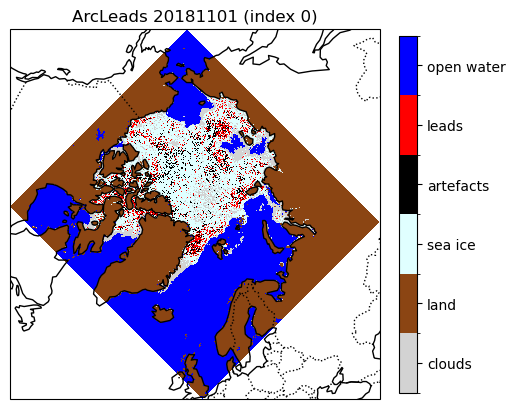

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['lightgrey','saddlebrown','lightcyan','black','red','blue']
labels = ['clouds','land','sea ice','artefacts','leads','open water']
cmap = ListedColormap(colors)
norm = BoundaryNorm([-0.5,0.5,1.5,2.5,3.5,4.5,5.5], cmap.N)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
ax = plt.subplot(1,1,1, projection=ccrs.NorthPolarStereo())
transform = ccrs.PlateCarree() if (np.nanmin(lon) >= -180 and np.nanmax(lon) <= 360) else ccrs.NorthPolarStereo()
mesh = ax.pcolormesh(lon, lat, leads, transform=transform, cmap=cmap, norm=norm, shading='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.title(f'ArcLeads {time[0]} (index {0})')
cbar = plt.colorbar(mesh, ax=ax, fraction=0.036, pad=0.04, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)
plt.show()